In [5]:
import pandas as pd 
import yfinance as yf 
from scipy.stats import spearmanr
import networkx as nx 
import numpy as np 

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

#read wikipedia S&P500 table into PD dataframe 
df_sp500 = pd.read_html(url)[0][['Symbol', 'Security', 'GICS Sector']] 
#ticker DF 
sp500_tickers = df_sp500['Symbol'].tolist() 

#read changes table into DF 
#sp500_changes = pd.read_html(url)[1]
#problematic 
# drop rows where at least one element missing
#changes = df_changes[['Date', 'Added', 'Removed']].dropna() 
#filter out reasons column 
#changes = changes[~changes['Date'].str.contains('Reason')]
#filter out note column 
#changes = changes[~changes['Date'].str.contains('Note')] 

#leaving these fuckers out (Berkshire Hathaway - 2010, Brown-Forman - 1982, AirBNB - 2023....so on)
#issues: these have not been in the dataset for the full time period (1258 days) so i need to leave them out until ifigure something out 
exclude = ['BRK.B', 'BF.B', 'ABNB', 'CARR', 'CEG', 'CTVA', 'DOW', 'FOXA', 'FOX', 'GEHC', 'KVUE', 'OTIS', 'UBER', 'VLTO'] 
sp500_tickers = [ticker for ticker in sp500_tickers if ticker not in exclude]

#dict for individual stock DF storage 
stockdataframes = {} 

start_dte = "2019-01-01"
end_dte = "2023-12-31"

#ADD INCLUSION AND EXCLUSION DATE AND FILTER BY THAT FOR NEWER STOCKS AND REMOVED ONES 

#iterate through all tickers+ get historical data 
for ticker in sp500_tickers: 
    #added = row['Added'] 
    #removed = row['Removed'] 
    
    try:
        stock = yf.Ticker(ticker) 
        stock_df = stock.history(start=start_dte, end=end_dte)[['Close']]
        
        #debug 
        #print(f"Debug - Ticker: {ticker}, DataFrame shape: {stock_df.shape}")
        
        #merge with wiki data - check if not empty first
        if 'Close' in stock_df.columns and not stock_df.empty: 
            stock_df['Symbol'] = ticker
            stock_df['Security'] = df_sp500[df_sp500['Symbol'] == ticker]['Security'].iloc[0]
            stock_df['GICS Sector'] = df_sp500[df_sp500['Symbol'] == ticker]['GICS Sector'].iloc[0]
            #merged_stock_df = pd.merge(stock_df, df_sp500[df_sp500['Symbol'] == ticker], left_index=True, right_index=True)
        
            #store merged df in dictionary 
            stockdataframes[ticker] = stock_df #used o be merged_stock_dataframe
        
            #print(f"Data fetched for {ticker}")
        else:
            print(f"Failed to fetch data for {ticker}: {e}")
    except Exception as e: 
        print(f"Failed to fetch data for {ticker}: {e}")

#merge all stock dfs into one 
full_df = pd.concat(stockdataframes.values(), keys=stockdataframes.keys())

full_df = full_df.reset_index(level=0) 

#ptiny 
print(full_df.head(450)) 
display(full_df) 
#full_df.to_csv('SP500.csv', index=True)


                          level_0       Close Symbol Security  GICS Sector
Date                                                                      
2019-01-02 00:00:00-05:00     MMM  153.602417    MMM       3M  Industrials
2019-01-03 00:00:00-05:00     MMM  147.818726    MMM       3M  Industrials
2019-01-04 00:00:00-05:00     MMM  153.900055    MMM       3M  Industrials
2019-01-07 00:00:00-05:00     MMM  153.546127    MMM       3M  Industrials
2019-01-08 00:00:00-05:00     MMM  154.189651    MMM       3M  Industrials
...                           ...         ...    ...      ...          ...
2020-10-07 00:00:00-04:00     MMM  142.362320    MMM       3M  Industrials
2020-10-08 00:00:00-04:00     MMM  143.405563    MMM       3M  Industrials
2020-10-09 00:00:00-04:00     MMM  144.765091    MMM       3M  Industrials
2020-10-12 00:00:00-04:00     MMM  144.209290    MMM       3M  Industrials
2020-10-13 00:00:00-04:00     MMM  142.482025    MMM       3M  Industrials

[450 rows x 5 columns]


,level_0,Close,Symbol,Security,GICS Sector
Date,,,,,
2019-01-02 00:00:00-05:00,MMM,153.602417,MMM,3M,Industrials
2019-01-03 00:00:00-05:00,MMM,147.818726,MMM,3M,Industrials
2019-01-04 00:00:00-05:00,MMM,153.900055,MMM,3M,Industrials
2019-01-07 00:00:00-05:00,MMM,153.546127,MMM,3M,Industrials
2019-01-08 00:00:00-05:00,MMM,154.189651,MMM,3M,Industrials
...,...,...,...,...,...
2023-12-22 00:00:00-05:00,ZTS,194.538773,ZTS,Zoetis,Health Care
2023-12-26 00:00:00-05:00,ZTS,195.057587,ZTS,Zoetis,Health Care
2023-12-27 00:00:00-05:00,ZTS,196.454422,ZTS,Zoetis,Health Care


In [6]:
#granger causality 
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import spearmanr

def calculate_granger_causality(data1, data2, max_lag=1, significance_level=0.05):
    # Granger causality test
    granger_result = grangercausalitytests(np.column_stack((data1, data2)), max_lag, verbose=False)
    
    #get ps 
    p_values = [granger_result[i+1][0]['ssr_ftest'][1] for i in range(max_lag)]
    
    # Check if any ps less than sig val 
    return any(p < significance_level for p in p_values)

stocks_by_symbol = {} 

for symbol, data in full_df.groupby('Symbol'):
    data.reset_index(inplace=True)
    stocks_by_symbol[symbol] = data[['Date','Close']]   

stock1_data = stocks_by_symbol['MMM']['Close']
stock2_data = stocks_by_symbol['ZTS']['Close']

#granger reesult gives true/false value
granger_result = calculate_granger_causality(stock1_data, stock2_data, max_lag=1, significance_level=0.07)
print("Granger causality between MMM and ZTS:", granger_result)


Granger causality between MMM and ZTS: False


/Users/khushi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [7]:
def spearman_ranking(a):
    input_array = np.array(a)
    sorted_indices = np.argsort(-input_array)
    ranks = np.empty_like(sorted_indices)
    ranks[sorted_indices] = np.arange(1, len(input_array) + 1)
    return ranks


def spearman_coefficient(stock1, stock2):
    a = spearman_ranking(stock1)
    b = spearman_ranking(stock2)
    n = (len(a) + len(b)) / 2
    rho = 1 - (6 * np.sum((a - b)**2) / (n * (n**2 - 1)))
    return rho

# print(len(monthly_df))
# Calculate Spearman correlation coefficient
#corr_matrix = monthly_df.pivot(columns='Symbol', values='Close').pct_change().corr(method='spearman').dropna()
# missing_values = last_day_df['Close'].isnull().sum()
# print(missing_values)
#corr_matrix = last_day_df.pivot(index='Date',columns='Symbol', values='Close').pct_change().corr(method='spearman').dropna()

#print(corr_matrix.head())
#print(len(corr_matrix))

#modified original functions to use granger instead of spearman- same logic
#currently working witth the boolean version of granger (true if p > 0.07) 
def create_base_network(granger_result, sp500_tickers):
    #create graph 
    G = nx.Graph() 

    for stock in sp500_tickers: 
        G.add_node(stock) 
        
    #add links 
    for i in range(len(sp500_tickers)): 
        for j in range(i + 1, len(sp500_tickers)):
            stock1 = sp500_tickers[i]
            stock2 = sp500_tickers[j]
            
            if granger_result:  # if true 
                G.add_edge(stock1, stock2, weight=1)  #add 
                
    return G

def create_sector_network(granger_result, sp500_tickers, sector_df, valid_sectors_array):
    #create graph 
    G = nx.Graph() 

    for stock in sp500_tickers: 
        if stock in sector_df['Symbol'].values:
            sector = sector_df.loc[sector_df['Symbol'] == stock, 'GICS Sector'].iloc[0]
            if sector in valid_sectors_array:
                G.add_node(stock, sector=sector) 
        
    node_list = list(G.nodes())
    #add links 
    for i in range(len(sp500_tickers)): 
        for j in range(i + 1, len(sp500_tickers)):
            stock1 = sp500_tickers[i]
            stock2 = sp500_tickers[j]
            #check if tickers in node list 
            if (stock1 not in node_list) or (stock2 not in node_list):
                continue
                
            if granger_result:  # If there's Granger causality
                G.add_edge(stock1, stock2, weight=1)  #edge has default weight 1=true 
                
    return G

    

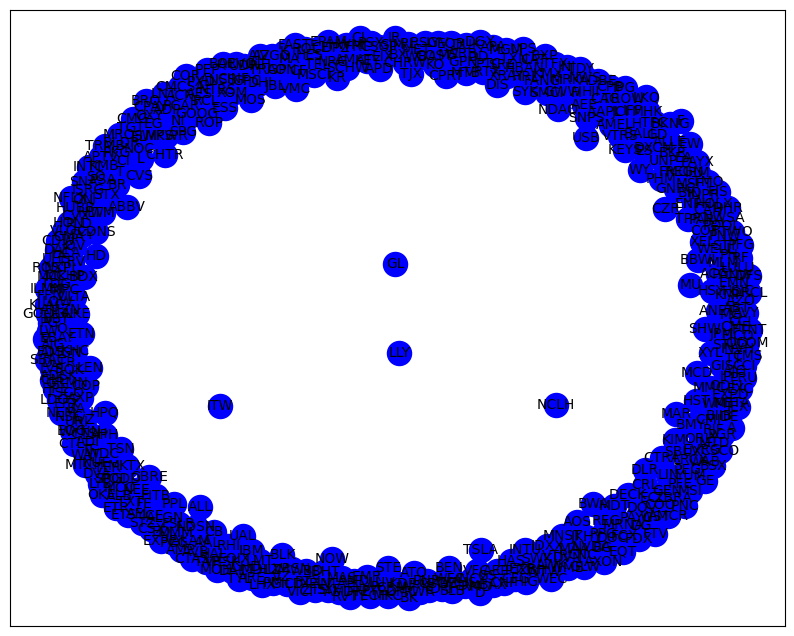

In [9]:
#testing granger visual - whole network 
import matplotlib.pyplot as plt

def draw_granger_network(G):
    plt.figure(figsize=(10,8))
    
    pos = nx.spring_layout(G) 
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='blue')
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
    plt.show()

G = create_base_network(granger_result, sp500_tickers)

draw_granger_network(G) 
    

NameError: name 'sector_df' is not defined

In [2]:
#fixing monthly data missing issue 
import pandas as pd 

filepath = 'SP500.csv' 
full_df = pd.read_csv(filepath) 

# Convert date to datetime
full_df['Date'] = pd.to_datetime(full_df['Date'], errors='coerce')

# Drop rows with NaT (Not a Time) values
full_df = full_df.dropna(subset=['Date'])

# Print the data type of the 'Date' column to ensure it's datetime-like
print(full_df['Date'].dtype)
print(full_df['Date'].head())

#non_date_values = full_df['Date'][pd.to_datetime(full_df['Date'], errors='coerce').isna()]
#print(non_date_values)

#find last trade days 
def last_trade_day(year, month): 
    lastday = pd.Timestamp(year, month, 1) + pd.offsets.MonthEnd(0) 
    while lastday.weekday() >= 5: #weekend days 
        lastday -= pd.Timedelta(days=1)
    return lastday 

# Create a new column 'Last_Trade_Day' with accurate last trading days
full_df['Last_Trade_Day'] = [last_trade_day(date.year, date.month) for date in full_df['Date']]

# Filter rows where 'Date' equals 'Last_Trade_Day'
last_day_df = full_df[full_df['Date'] == full_df['Last_Trade_Day']]

# Reset index
last_day_df = last_day_df.reset_index(drop=True)

print(len(last_day_df))
print(last_day_df.head())

#func call to each row 
#lastdays = [last_trade_day(year, month) for year, month in zip(full_df['Date'].dt.year, full_df['Date'].dt.month)]
#lastdays = [last_trade_day(date.year, date.month) for date in full_df['Last_Trade_Day']]

#add accurate last days to df 
#full_df['Last_Trade_Day'] = lastdays 

#filtering 
#last_day_df = full_df[full_df['Date'] == full_df['Last_Trading_Day']]

#reset index 

#print(len(last_day_df))
#print(last_day_df.head())




object
0    2019-01-02 00:00:00-05:00
1    2019-01-03 00:00:00-05:00
2    2019-01-04 00:00:00-05:00
3    2019-01-07 00:00:00-05:00
4    2019-01-08 00:00:00-05:00
Name: Date, dtype: object
0
Empty DataFrame
Columns: [Date, level_0, Close, Symbol, Security, GICS Sector, Last_Trade_Day]
Index: []


In [2]:
"""
import matplotlib.pyplot as plt 

monthly_df = full_df.resample('M').last() 

# Calculate Spearman correlation coefficient
corr_matrix = monthly_df.pivot(columns='Symbol', values='Close').pct_change().corr(method='spearman').dropna()

#create graph 
G = nx.Graph() 

for stock in sp500_tickers: 
    G.add_node(stock) 
    
#add links 
for i in range(len(sp500_tickers)): 
    for j in range(i + 1, len(sp500_tickers)):
        stock1 = sp500_tickers[i]
        stock2 = sp500_tickers[j]
        
        # Check if the stock symbols are present in the correlation matrix
        if stock1 in corr_matrix.index and stock2 in corr_matrix.columns:
            correlation_coefficient = corr_matrix.loc[stock1, stock2]
            if not np.isnan(correlation_coefficient):
                G.add_edge(stock1, stock2, weight=correlation_coefficient)

#visualization 
pos = nx.spring_layout(G, seed=42)
# Draw only edges with significant correlation
edges = [(source, target) for source, target, data in G.edges(data=True) if abs(data['weight']) > 0.5]
nx.draw_networkx_nodes(G, pos, node_size=30)
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='gray')

labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()
"""

2

In [ ]:
#REF 
#import pandas as pd 
#import yfinance as yf 

#url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

#read tables into PD dataframe 
#dfs = pd.read_html(url) 

#get first table (index 0) + first 3 cols 
#df = dfs[0].iloc[:, :3] 
#print(df) 